## Phase 1 Pipeline

In [712]:
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils
import glob

28229


(52, 118, 3)

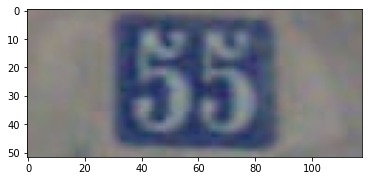

In [713]:
#i=16
i = random.randint(1,33402)
print(i)
img = cv2.imread(f'data/train/{i}.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
height = img.shape[0]
width = img.shape[1]
img.shape

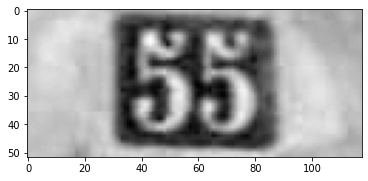

In [714]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')


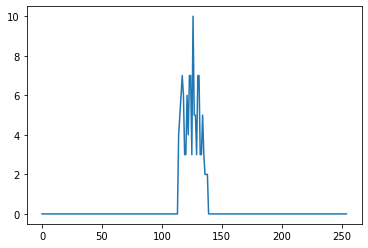

In [715]:
hist = cv2.calcHist(gray,[0],None,[255],[0,255])
plt.plot(hist)

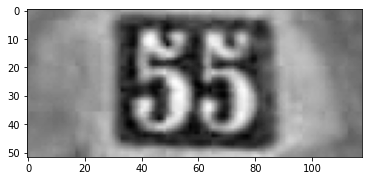

In [716]:
clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(5,5))
cl1 = clahe.apply(gray)
plt.imshow(cl1,cmap='gray')

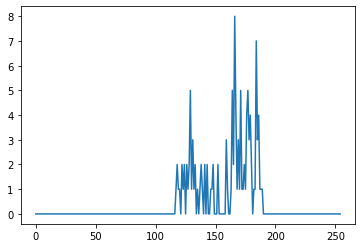

In [717]:
hist = cv2.calcHist(cl1,[0],None,[255],[0,255])
plt.plot(hist)

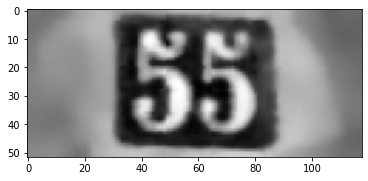

In [718]:
bfilter= cv2.bilateralFilter(cl1,11,17,17) #Better than gaussian because it keeps edges sharp
plt.imshow(bfilter,cmap='gray')

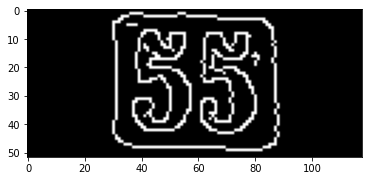

In [719]:
edges = cv2.Canny(bfilter,30,100)
plt.imshow(edges,cmap='gray')

9

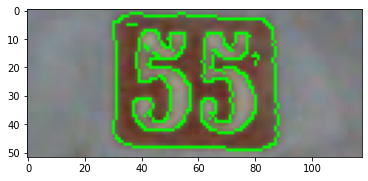

In [720]:
keypoints= cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours=imutils.grab_contours(keypoints)
edged_cont = cv2.drawContours(img.copy(), contours, -1, (0,255,0), 1)
plt.imshow(edged_cont)
sorted_contours=sorted(contours,key=cv2.contourArea,reverse=True)
len(sorted_contours)

[[30, 1, 89, 50],
 [30, 1, 89, 50],
 [37, 7, 58, 43],
 [61, 8, 81, 44],
 [37, 7, 58, 43],
 [61, 8, 81, 44]]

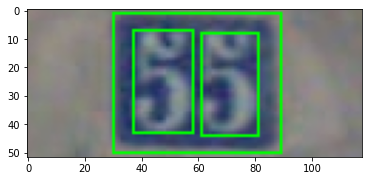

In [721]:
pred_contours = []
real_contours = []
pred_boxes = img.copy()
for contour in sorted_contours:
    [x, y, w, h] = cv2.boundingRect(contour)
    if ( (h*w > 0.015*height*width) and (y<0.5*height) and (0.25*width< x <0.75*width)):
        pred_contours.append([x, y, x+w, y+h])
        real_contours.append(contour)
        cv2.rectangle(pred_boxes, (x,y), (x+w,y+h), (0,255,0), 1)
plt.imshow(cv2.cvtColor(pred_boxes,cv2.COLOR_BGR2RGB))

pred_contours

In [722]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	
    # compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [723]:
def removeDuplicateContours(pred_contours):
    # Corner Case: Image has only 1 digit and 1 contour predicted 
    if(len(pred_contours)==1):
        return pred_contours
    
    real_contours2 = []
    filtered_contours = []
    #pred_contours = [list(x) for x in set([tuple(L) for L in pred_contours])]
    i=0
    while(i<len(pred_contours)):
        filtered_contours.append(pred_contours[i])
        real_contours2.append(real_contours[i])
        # Corner Case: Last two contours are not duplicates
        if i == len(pred_contours)-1:
            break    
        j=i+1
        while(j<len(pred_contours)):
            iou = bb_intersection_over_union(pred_contours[i], pred_contours[j])
            if iou>0.8:
                pred_contours.pop(j)  
            j+=1
        i+=1     
    return filtered_contours, real_contours2
    """
    i=0
    while(i<len(pred_contours)-1):
        iou = bb_intersection_over_union(pred_contours[i], pred_contours[i+1])
        if iou>0.8:
            filtered_contours.append(pred_contours[i])
            i+=1
        else:
            filtered_contours.append(pred_contours[i])
        i+=1
    return filtered_contours
    """

In [724]:
filtered_contours, real_contours2 = removeDuplicateContours(pred_contours)

filtered_contours

[[30, 1, 89, 50], [37, 7, 58, 43], [61, 8, 81, 44]]

In [725]:
digitStruct = pd.read_json('data/train/digitStruct.json')

digitStruct.set_index('filename', inplace=True)

digitStruct.head()

,boxes
filename,
1.png,"[{'height': 219.0, 'label': 1.0, 'left': 246.0..."
2.png,"[{'height': 32.0, 'label': 2.0, 'left': 77.0, ..."
3.png,"[{'height': 15.0, 'label': 2.0, 'left': 17.0, ..."
4.png,"[{'height': 34.0, 'label': 9.0, 'left': 57.0, ..."
5.png,"[{'height': 46.0, 'label': 3.0, 'left': 52.0, ..."


In [726]:
def get_gt_contours(i):
    gt_contours = []
    boxes = digitStruct.loc[f'{str(i)}.png', 'boxes']
    for box in boxes:
        x = box['left']
        y = box['top']
        w = box['width']
        h = box['height']
        gt_contours.append([x, y, x+w, y+h])
    return gt_contours

In [727]:
gt_contours = get_gt_contours(i)
print(len(gt_contours))
gt_contours


2


[[37.0, 5.0, 59.0, 43.0], [60.0, 7.0, 83.0, 45.0]]

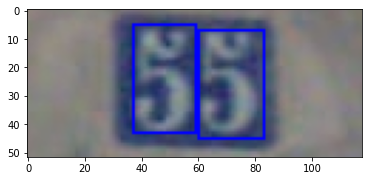

In [728]:
gt_boxes = img.copy()
for contour in gt_contours:
    contour = list(map(int, contour)) # To cast all point values to integers (loaded from json file as float)
    [x1, y1, x2, y2] = contour
    cv2.rectangle(gt_boxes, (x1,y1), (x2,y2), (255,0,0), 1)
plt.imshow(cv2.cvtColor(gt_boxes, cv2.COLOR_BGR2RGB))

In [729]:
match_contours = []
for i, filtered_contour in enumerate(filtered_contours):
    for gt_contour in gt_contours:
        iou = bb_intersection_over_union(filtered_contour, gt_contour)
        if iou > 0.4:
            match_contours.append({'box': filtered_contour, 'iou':iou, 'contour':real_contours2[i]})

print(len(match_contours))
match_contours


2


[{'box': [37, 7, 58, 43],
  'iou': 0.907469342251951,
  'contour': array([[[35,  2]],
  
         [[36,  1]],
  
         [[40,  1]],
  
         [[41,  2]],
  
         [[52,  2]],
  
         [[53,  1]],
  
         [[55,  1]],
  
         [[56,  2]],
  
         [[66,  2]],
  
         [[67,  3]],
  
         [[82,  3]],
  
         [[86,  7]],
  
         [[86, 10]],
  
         [[87, 11]],
  
         [[86, 12]],
  
         [[87, 13]],
  
         [[87, 16]],
  
         [[86, 17]],
  
         [[86, 18]],
  
         [[87, 19]],
  
         [[87, 32]],
  
         [[88, 33]],
  
         [[88, 34]],
  
         [[87, 35]],
  
         [[87, 36]],
  
         [[88, 37]],
  
         [[88, 40]],
  
         [[87, 41]],
  
         [[87, 42]],
  
         [[88, 43]],
  
         [[88, 44]],
  
         [[87, 45]],
  
         [[87, 46]],
  
         [[86, 47]],
  
         [[85, 47]],
  
         [[84, 48]],
  
         [[83, 48]],
  
         [[82, 49]],
  
         [[70, 49]],
  

In [730]:
# Corner Case: Matched contours > the actual digits in image ()
if len(match_contours) > len(gt_contours):
    match_contours = sorted(match_contours, key=lambda c: c['iou'], reverse=True)
    match_contours = match_contours[:len(gt_contours)]
match_contours

[{'box': [37, 7, 58, 43],
  'iou': 0.907469342251951,
  'contour': array([[[35,  2]],
  
         [[36,  1]],
  
         [[40,  1]],
  
         [[41,  2]],
  
         [[52,  2]],
  
         [[53,  1]],
  
         [[55,  1]],
  
         [[56,  2]],
  
         [[66,  2]],
  
         [[67,  3]],
  
         [[82,  3]],
  
         [[86,  7]],
  
         [[86, 10]],
  
         [[87, 11]],
  
         [[86, 12]],
  
         [[87, 13]],
  
         [[87, 16]],
  
         [[86, 17]],
  
         [[86, 18]],
  
         [[87, 19]],
  
         [[87, 32]],
  
         [[88, 33]],
  
         [[88, 34]],
  
         [[87, 35]],
  
         [[87, 36]],
  
         [[88, 37]],
  
         [[88, 40]],
  
         [[87, 41]],
  
         [[87, 42]],
  
         [[88, 43]],
  
         [[88, 44]],
  
         [[87, 45]],
  
         [[87, 46]],
  
         [[86, 47]],
  
         [[85, 47]],
  
         [[84, 48]],
  
         [[83, 48]],
  
         [[82, 49]],
  
         [[70, 49]],
  

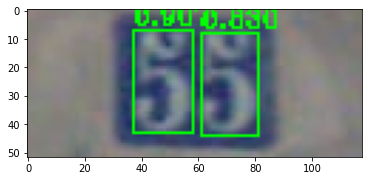

In [731]:
match_boxes = img.copy()
for contour in match_contours:
    [x1, y1, x2, y2] = contour['box']
    cv2.rectangle(match_boxes, (x1,y1), (x2,y2), (0,255,0), 1)
    
    cv2.putText(match_boxes, "{:.3f}".format(contour['iou']), (x1, y1-2), cv2.FONT_HERSHEY_TRIPLEX, 0.3, (0, 255, 0), 1)

plt.imshow(cv2.cvtColor(match_boxes, cv2.COLOR_BGR2RGB))

In [732]:
true_pos = len(match_contours)
false_pos = len(filtered_contours) - len(match_contours)
false_neg = len(gt_contours) - len(match_contours)

precision = true_pos / (true_pos + false_pos)

recall = true_pos / (true_pos + false_neg)

if true_pos == 0:
    f1_score = 0
else:
    f1_score = (2*precision*recall) / (precision+recall)

print(precision)
print(recall)
print(f1_score)

0.6666666666666666
1.0
0.8


## Phase 2 Trial (matchShapes())

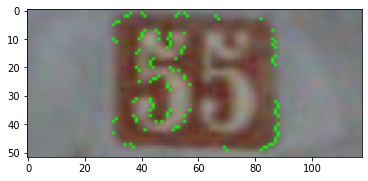

In [733]:
img_cpy = img.copy()
for digit in match_contours:
    digit_contour = digit['contour']
    cv2.drawContours(img_cpy, digit_contour,-1,(0,255,0),1)
plt.figure()
plt.imshow(img_cpy)


new digit
[10.176323560175964, 0.7271309172112157, 6.465846321432754, 6.23108390402469, 3.4028334439324985, 6.993833519701515, 1.6182191340045178, 12.855242822391338, 1.4456759527161012, 1.5673635712994587]
0.7271309172112157
new digit
[6.259965811484035, 4.982368901033665, 3.030254797453737, 3.179168128085352, 4.38286145191783, 5.241492916029508, 4.912566251297007, 9.261594565983, 4.8456519400751565, 4.358369712172591]
3.030254797453737


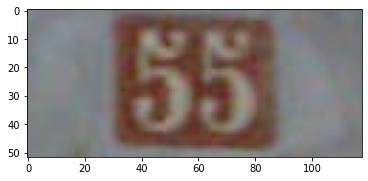

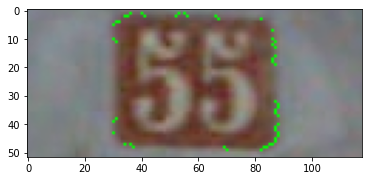

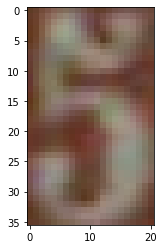

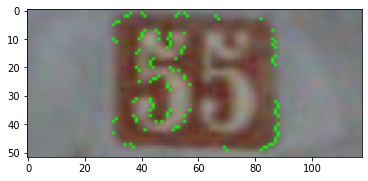

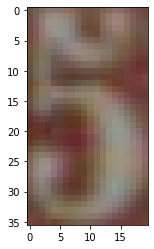

In [734]:

plt.imshow(img)
for digit in match_contours:
    [x1, y1, x2, y2] = digit['box']
    digit_contour = digit['contour']
    digit_img = img.copy()[y1:y2, x1:x2]
    cv2.drawContours(img, digit_contour,-1,(0,255,0),1)
    plt.figure()
    plt.imshow(img)
    print("new digit")

    #gray = cv2.cvtColor(digit_img, cv2.COLOR_BGR2GRAY)
    #ret, img_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    #cnts_img, heir = cv2.findContours(img_thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    #cnts_img=sorted(cnts_img,key=cv2.contourArea,reverse=True)
    #print('cnts:', len(cnts_img))
    #cnt_img = cnts_img[0]
    #cv2.drawContours(digit_img, cnts_img,-1,(0,255,0),1)
    cv2.drawContours(digit_img, digit_contour,-1,(0,255,0),1)
    plt.figure()
    plt.imshow(digit_img)


    i = 0
    probs= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    sum=0
    #print(len(glob.glob('Matching/*.jpg')))
    #print(glob.glob('numbers/templates/*.png'))

    for tmp_path in glob.glob('numbers/templates/*.png'):
        tmp = cv2.imread(tmp_path)
        gray = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
        ret, img_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
        cnts, heir = cv2.findContours(img_thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
        cnts=sorted(cnts,key=cv2.contourArea,reverse=True)
        cv2.drawContours(tmp,cnts,-1,(0,255,0),1)
        ret = cv2.matchShapes(digit_contour,cnts[0],1,0.0)
        
        """
        sum+=ret
        # print(ret, tmp_path)
        if(i%2==1):
            probs.append(sum/2)
            print(sum/2)
            sum=0
            #i=0
        i+=1
        """
        idx = int(i%10)
        probs[idx] += ret
        
        i+=1

        # print(tmp_path,len(cnts))
        # plt.figure()
        # plt.imshow(tmp)
    print(probs)
    print(min(probs))


28975

numbers/templates\row-1-column-1.png 1
numbers/templates\row-1-column-10.png 2
numbers/templates\row-1-column-2.png 1
numbers/templates\row-1-column-3.png 1
numbers/templates\row-1-column-4.png 1
numbers/templates\row-1-column-5.png 1
numbers/templates\row-1-column-6.png 2
numbers/templates\row-1-column-7.png 1
numbers/templates\row-1-column-8.png 3
numbers/templates\row-1-column-9.png 2
numbers/templates\row-2-column-1.png 1
numbers/templates\row-2-column-10.png 2
numbers/templates\row-2-column-2.png 2
numbers/templates\row-2-column-3.png 1
numbers/templates\row-2-column-4.png 2
numbers/templates\row-2-column-5.png 1
numbers/templates\row-2-column-6.png 2
numbers/templates\row-2-column-7.png 1
numbers/templates\row-2-column-8.png 3
numbers/templates\row-2-column-9.png 2
numbers/templates\row-3-column-1.png 1
numbers/templates\row-3-column-10.png 2
numbers/templates\row-3-column-2.png 1
numbers/templates\row-3-column-3.png 1
numbers/templates\row-3-column-4.png 2
numbers/templates\row-

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_18308\2819186271.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


numbers/templates\row-4-column-10.png 2
numbers/templates\row-4-column-2.png 4
numbers/templates\row-4-column-3.png 2
numbers/templates\row-4-column-4.png 1
numbers/templates\row-4-column-5.png 2
numbers/templates\row-4-column-6.png 2
numbers/templates\row-4-column-7.png 1
numbers/templates\row-4-column-8.png 3
numbers/templates\row-4-column-9.png 2
numbers/templates\row-6-column-1.png 1
numbers/templates\row-6-column-10.png 2
numbers/templates\row-6-column-2.png 1
numbers/templates\row-6-column-3.png 1
numbers/templates\row-6-column-4.png 2
numbers/templates\row-6-column-5.png 1
numbers/templates\row-6-column-6.png 2
numbers/templates\row-6-column-7.png 1
numbers/templates\row-6-column-8.png 3
numbers/templates\row-6-column-9.png 2


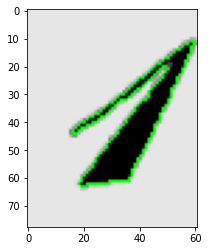

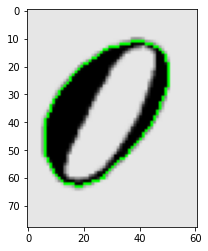

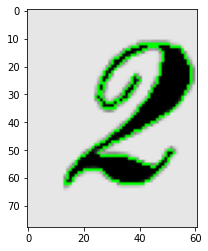

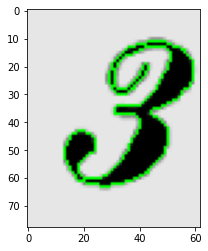

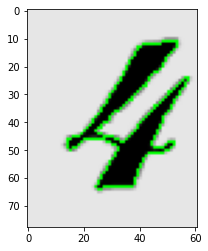

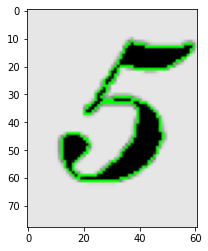

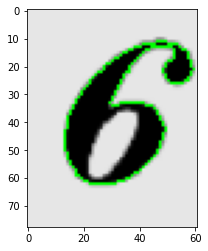

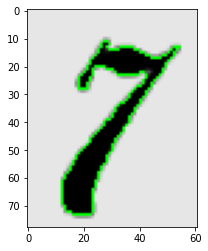

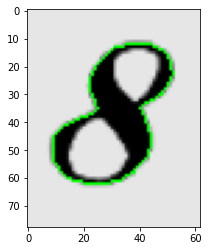

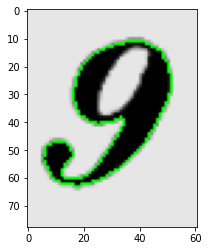

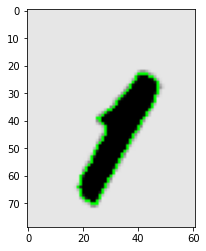

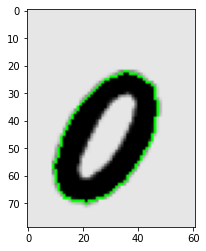

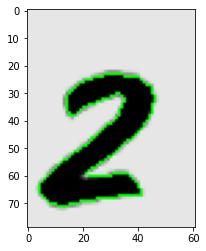

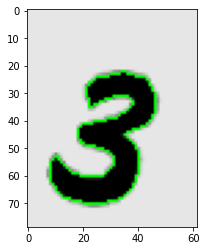

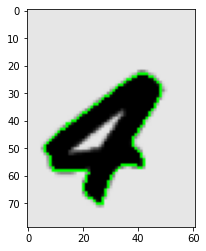

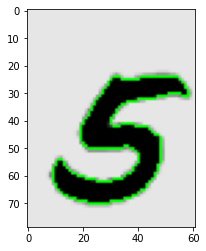

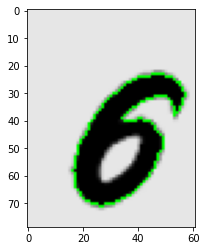

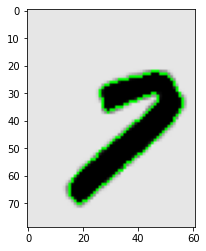

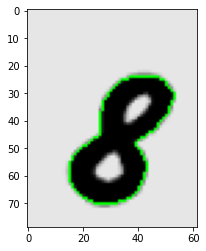

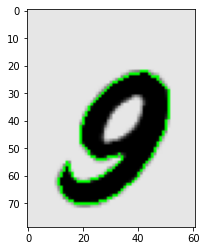

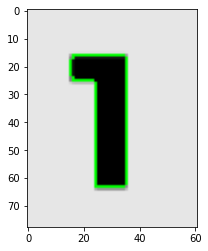

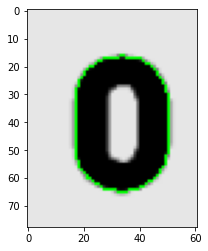

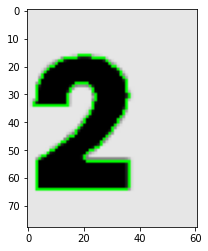

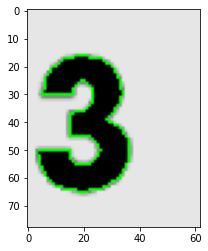

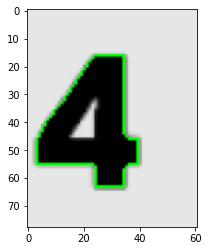

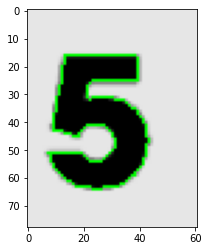

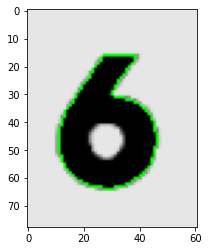

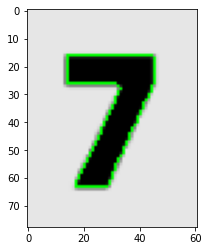

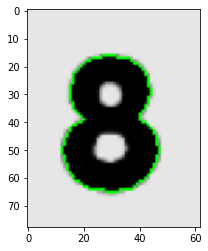

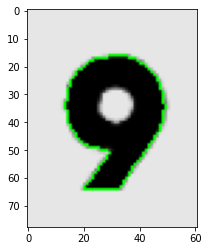

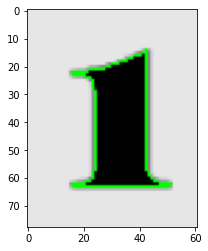

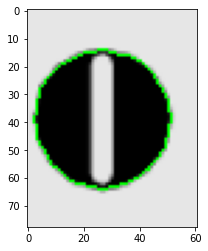

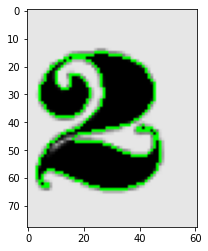

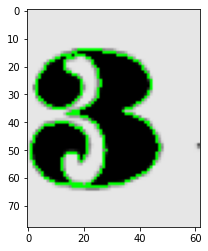

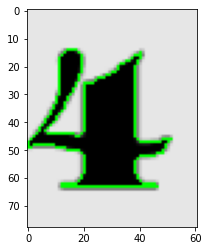

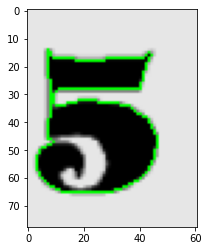

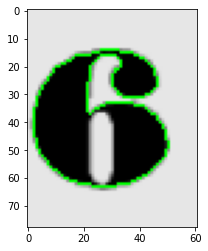

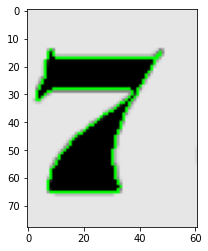

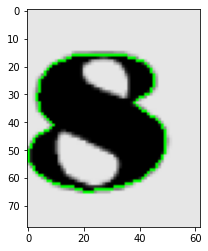

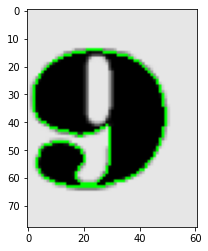

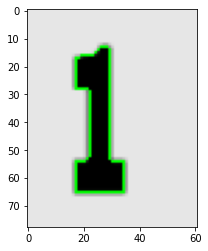

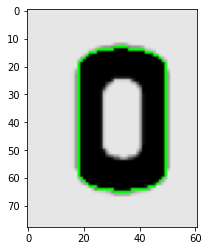

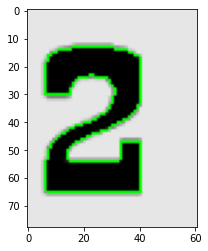

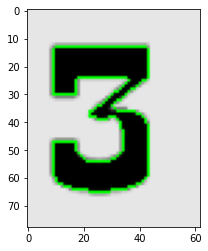

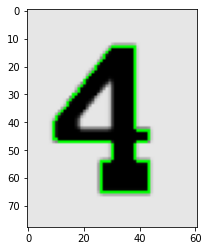

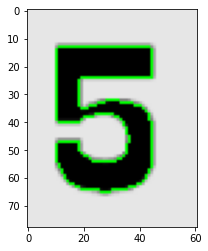

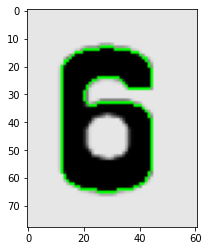

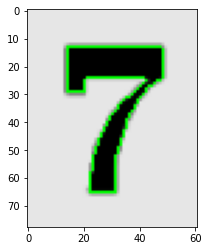

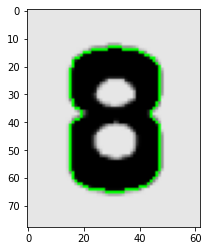

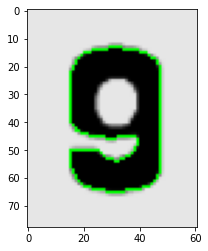

In [735]:
for tmp_path in glob.glob('numbers/templates/*.png'):
        tmp = cv2.imread(tmp_path)
        gray = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
        ret, img_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
        cnts, heir = cv2.findContours(img_thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
        cnts=sorted(cnts,key=cv2.contourArea,reverse=True)
        cv2.drawContours(tmp,cnts[0],-1,(0,255,0),1)
        print(tmp_path, len(cnts))
        plt.figure()
        plt.imshow(tmp)
        
